In [3]:
import os
import sys

project_root = os.getcwd()
while "src" not in os.listdir(project_root):
    project_root = os.path.dirname(project_root)
sys.path.append(project_root)

In [4]:
import torch
import librosa
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
from src.pipelines import musdb_pipeline, train_pipeline, eval_pipeline, infer_pipeline
from src.models import DeepSampler, SCUNet, SimpleUNet
from src.utils.training import MultiSourceLoss, VGGFeatureLoss, MultiScaleLoss
import numpy as np

plt.rcParams["figure.figsize"] = [20, 6]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-02-15 19:04:52.060066: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-15 19:04:52.149804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739664292.207544   21872 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739664292.224687   21872 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 19:04:52.322854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
nfft = 2048
hop_length = 512
window = torch.hann_window(nfft)
chunk_seconds = 2
overlap = 0
sr = 44100

data_root = os.path.join(project_root, "data")
musdb_root = os.path.join(data_root, "musdb18hq")

if not os.path.exists(data_root):
    raise FileNotFoundError(
        "No se encontró la carpeta data, por favor ejecute el script download_data.sh antes de ejecutar este script."
    )

In [7]:
train_dataset = musdb_pipeline(
    musdb_path=os.path.join(musdb_root, "train"),
    nfft=nfft,
    hop_length=hop_length,
    window=window,
    chunk_seconds=chunk_seconds,
    overlap=overlap,
    sample_rate=sr,
    max_samples=300,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True
)

Procesando pistas:   2%|▏         | 2/100 [00:01<01:24,  1.15it/s]

Se han procesado 300 segmentos.


In [ ]:
test_dataset = musdb_pipeline(
    musdb_path=os.path.join(musdb_root, "test"),
    nfft=nfft,
    hop_length=hop_length,
    window=window,
    chunk_seconds=chunk_seconds,
    overlap=overlap,
    sample_rate=sr,
    max_samples=300,
)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [8]:
deep_sampler = DeepSampler()
optimizer = optim.Adam(deep_sampler.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = MultiSourceLoss(
    weights=[1, 1, 1, 1],
    distance="l1",
)

factor = 1
epochs = 2 * factor
p1_epochs = 1 * factor
deep_sampler.to(device)

DeepSampler(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.2, inplace=False)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.2, inplace=False)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, e

In [10]:
history = train_pipeline(
    model=deep_sampler,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    total_epochs=epochs,
    phase1_epochs=p1_epochs,
    device=device,
)

Epoch 1/2 - Avg Loss: 0.1022 - LR: 1.0e-03 - Time: 14.09s - ETA: 14.09s

Starting second training phase (lr=1e-4)


Epoch 2/2 - Avg Loss: 0.0883 - LR: 1.0e-03 - Time: 13.35s - ETA: 0.00s

Training complete. Total time: 27.44168186187744 seconds.


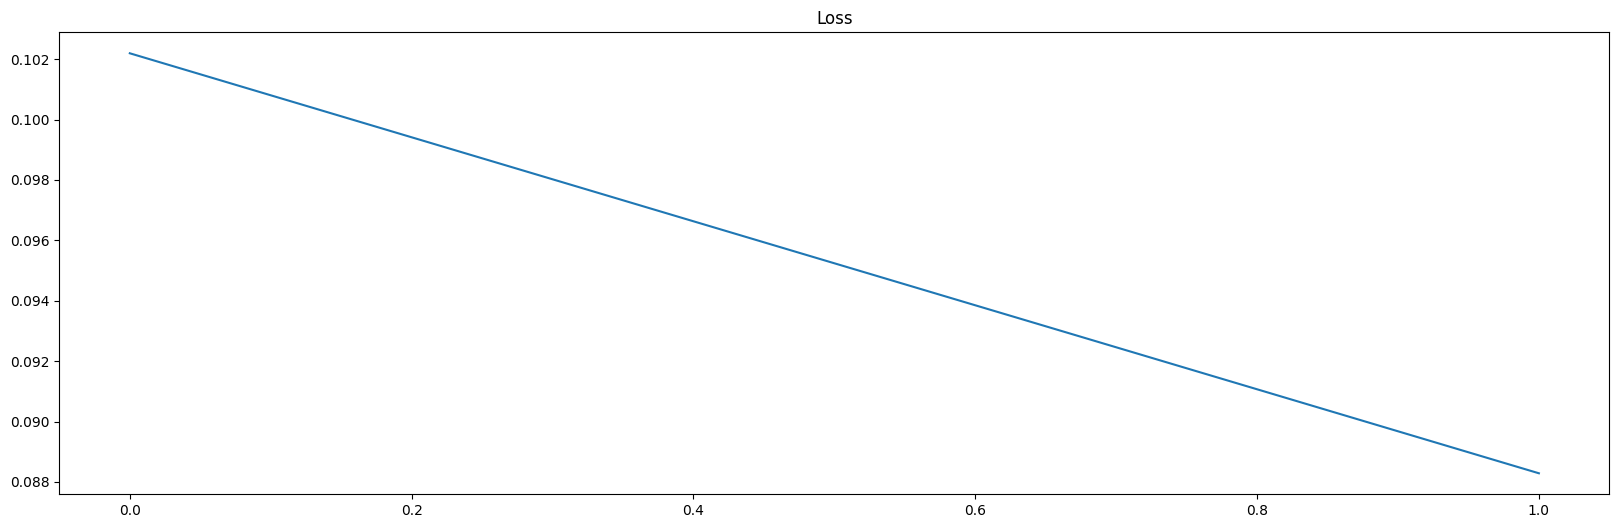

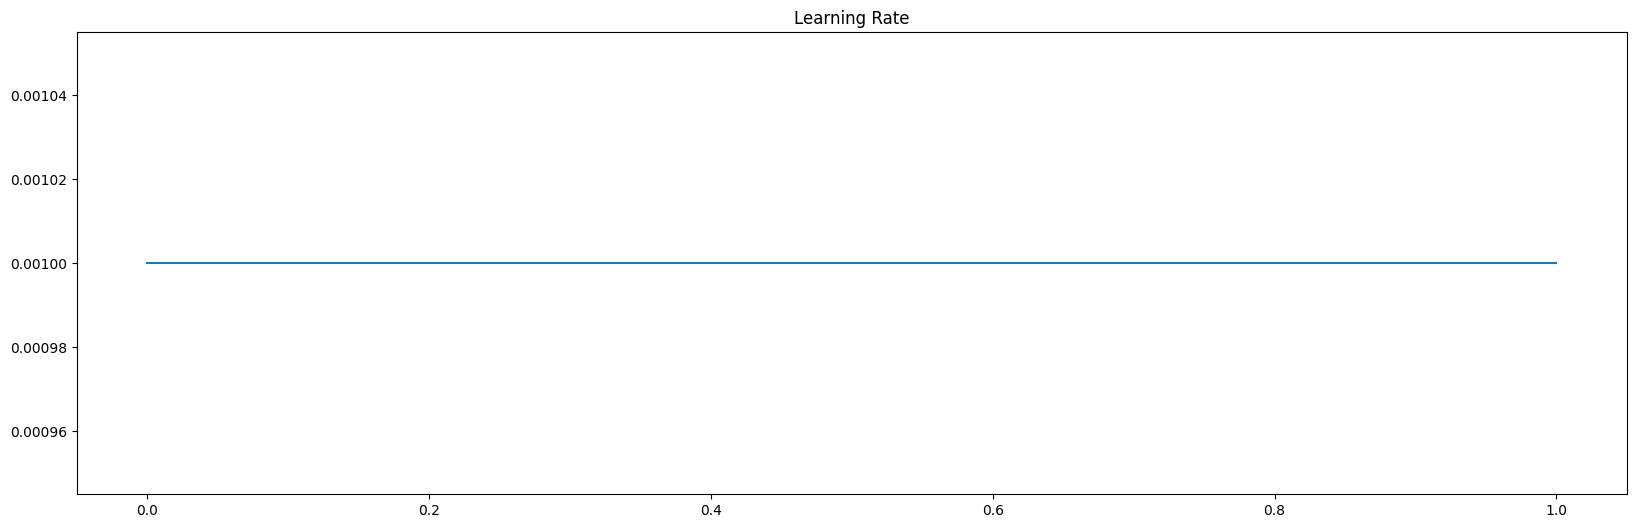

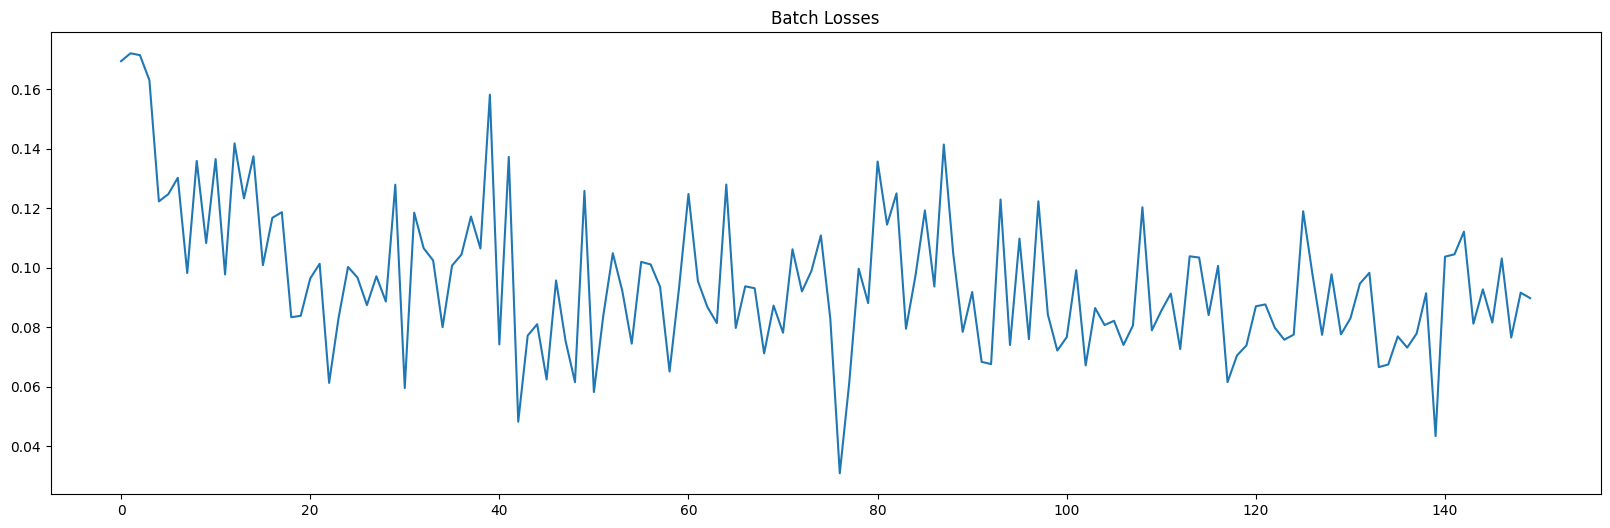

In [11]:
# plot history = {"epoch_loss": [], "learning_rate": [], "batch_losses": []}
plt.plot(history["epoch_loss"])
plt.title("Loss")
plt.show()

plt.plot(history["learning_rate"])
plt.title("Learning Rate")
plt.show()

plt.plot(np.array(history["batch_losses"]).flatten())
plt.title("Batch Losses")
plt.show()

In [ ]:
test_folders = os.listdir(os.path.join(musdb_root, "test"))
random_folder = np.random.choice(test_folders)

audio_mixture = os.path.join(musdb_root, "test", random_folder, "mixture.wav")

In [ ]:
sources = infer_pipeline(
    model=deep_sampler,
    mixture_path=audio_mixture,
    sample_rate=44100,
    chunk_seconds=chunk_seconds,
    overlap=overlap,
    n_fft=nfft,
    hop_length=hop_length,
    device=device,
)

In [ ]:
inst = ["vocals", "drums", "bass", "other"]

In [ ]:
for instrument in inst:
    file_path = os.path.join(musdb_root, "test", random_folder, f"{instrument}.wav")
    wav, _ = librosa.load(file_path, sr=44100)
    plt.figure(figsize=(20, 6))
    plt.plot(wav)
    plt.title(instrument)
    plt.show()

In [ ]:
for i, s in enumerate(inst):
    plt.figure(figsize=(20, 6))
    plt.plot(sources[s])
    plt.title(s)
    plt.show()

In [ ]:
# Create experiments folder with checkpoints, logs and results
experiments_path = os.path.join(project_root, "experiments")
if not os.path.exists(experiments_path):
    os.mkdir(experiments_path)

experiment_name = "deep_sampler"
experiment_path = os.path.join(experiments_path, experiment_name)
if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

# Save model
model_path = os.path.join(experiment_path, "model.pth")
torch.save(deep_sampler.state_dict(), model_path)

# Save history
history_path = os.path.join(experiment_path, "history.pth")
torch.save(history, history_path)

# Save sources
sources_path = os.path.join(experiment_path, "sources.pth")
torch.save(sources, sources_path)